# Song Challenge

## Challenge description:
You are the fifth employee at company XYZ. The good news is that if the company becomes
big, you will become very rich with the stocks. The bad news is that, at such an early stage, the
data is usually very messy. All their data is stored in json files.
<br>
The company CEO asked you very specific questions:
- What are the top 3 and the bottom 3 states in terms of number of users?
- What are the top 3 and the bottom 3 states in terms of user engagement? You can
choose how to mathematically define user engagement. What the CEO cares about here
is in which states users are using the product a lot/very little.
<br>
- The CEO wants to send a gift to the first user who signed-up for each state. That is, the
first user who signed-up from California, from Oregon, etc. Can you give him a list of
those users?
- Build a function that takes as an input any of the songs in the data and returns the most
likely song to be listened next. That is, if, for instance, a user is currently listening to
"Eight Days A Week", which song has the highest probability of being played right after it
by the same user? This is going to be v1 of a song recommendation model.
- How would you set up a test to check whether your model works well and is improving
engagement?

In [34]:
import pandas as pd
import json
import datetime

import IPython.display

In [5]:
# Import the json file into a dataframe
song_df = pd.read_json('song.json')
song_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 4000 non-null   object
 1   user_id            4000 non-null   int64 
 2   user_state         4000 non-null   object
 3   user_sign_up_date  4000 non-null   object
 4   song_played        4000 non-null   object
 5   time_played        4000 non-null   object
dtypes: int64(1), object(5)
memory usage: 187.6+ KB


### What are the top 3 and the bottom 3 states in terms of number of users?

In [29]:
top_bottom_states = pd.DataFrame(song_df.groupby('user_state')['user_id'].nunique())
top_bottom_states.sort_values(by='user_id', ascending = False, inplace = True)

top3_states = top_bottom_states.head(3)
bottom3_states = top_bottom_states[top_bottom_states['user_id'] == 1] # There are several states that have only one user

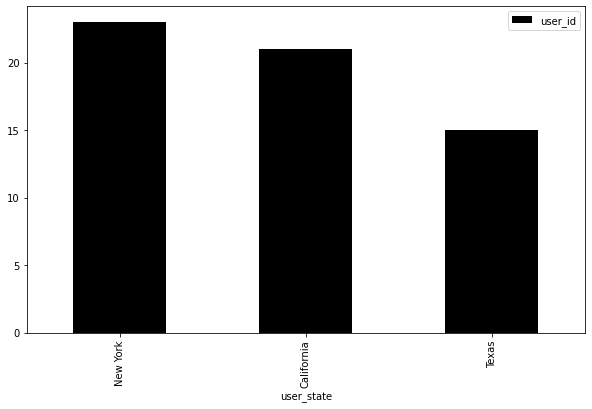

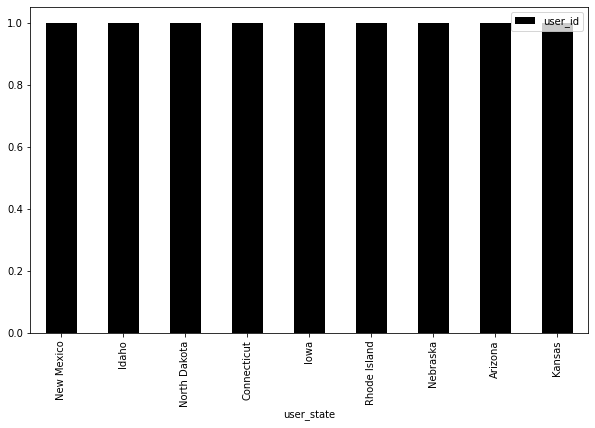

In [30]:
top3_states.plot(kind='bar', figsize=(10,6), color='black')
bottom3_states.plot(kind='bar', figsize=(10,6), color='black')

In [32]:
top_bottom_states['users_perc'] = top_bottom_states['user_id'] / top_bottom_states['user_id'].sum()
top_bottom_states['users_perc_cum'] = top_bottom_states['users_perc'].cumsum()
top_bottom_states

,user_id,users_perc,users_perc_cum
user_state,,,
New York,23,0.117347,0.117347
California,21,0.107143,0.224490
Texas,15,0.076531,0.301020
Pennsylvania,9,0.045918,0.346939
Ohio,9,0.045918,0.392857
Illinois,7,0.035714,0.428571
Florida,7,0.035714,0.464286
North Carolina,6,0.030612,0.494898
New Jersey,6,0.030612,0.525510


#### Answer:
- The top 3 states with the highest number of users are NY, CA and TX. Those 3 alone accounts for 30% of the total user base.
- There are 9 states with only one user. In order to define which one are the bottom 3, we could look at which one have the lowest usage amongst those 9

### What are the top 3 and the bottom 3 states in terms of user engagement? You can choose how to mathematically define user engagement. What the CEO cares about here is in which states users are using the product a lot/very little.

In [49]:
# Create a summary dataframe of engagement at user level 
# We will define engagement as a combination of frequency and recency (number of song played and number of das since it was last played)

# Frequency
engagement_f = pd.DataFrame(song_df.groupby('user_id')['id'].count())

# Recency
song_df['n_days_played'] = pd.to_datetime('2015-12-31') - pd.to_datetime(song_df['time_played']) # using end of 2015 as today's date
engagement_r = pd.DataFrame(song_df.groupby('user_id')['n_days_played'].min()) - song_df['n_days_played'].min() # relative to most recently played song overall
engagement_r['n_days_played'] = engagement_r['n_days_played'].dt.days

# Combined (give a higher weight to frequency than recency)
engagement_overall = engagement_f.join(engagement_r)
engagement_overall.rename(columns={'id':'n_songs'}, inplace = True)
engagement_overall['engagement_score'] = engagement_overall['n_songs'] + (engagement_overall['n_days_played'] * 0.5) 

# Standardize the engagement score 
engagement_overall['engagement_score'] = engagement_overall['engagement_score'] / engagement_overall['engagement_score'].max()
display(engagement_overall['engagement_score'].min())
display(engagement_overall['engagement_score'].median())
display(engagement_overall['engagement_score'].max())

0.028846153846153848

0.38461538461538464

1.0

In [50]:
# Merge engagement_score to main songs_df


,n_songs,n_days_played,engagement_score
user_id,,,
1,10,3,0.221154
2,18,3,0.375000
3,18,0,0.346154
4,17,0,0.326923
5,21,3,0.432692
...,...,...,...
196,25,1,0.490385
197,3,8,0.134615
198,23,1,0.451923
